# Aquaseca basic domain
## Former Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 


*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [4]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#additional analysis tools
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)


moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws = "D:/mfoutput"

#jupyter specific--included to show plots in notebook
%matplotlib inline 

##  Discretization and other inputs

In [5]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

width = 100
dx= width #width of grid cells in x direction 
dy= width #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('../base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 10e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (25.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 


rip_rows_forced = (22.0, 29.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

Rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
Rip_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 


## Recharge
rech= 0.003 #m/d

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 20 cols
rech_cols_forced = (1.0, 15.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech

## Boundary conditions
h_right = 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#Aqua Seca Well well
pumping = -5000 #m3/day 
well_row =   19 
well_col =   32 

wel_spd =  {0: [2,well_row, well_col, pumping]}



### Layering

In [6]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 

## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array

## Make some changes to the parameters
bot_elev = 0. #0
mid_elev = 40. #40
top_elev = 45. #45

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [7]:
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,0,49]=0
ibound[:,49,49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#new bottom no flow zone constriction
ibound[:,1,19:]=0
ibound[:,2,25:]=0
ibound[:,3,30:]=0
ibound[:,4,33:]=0
ibound[:,5,36:]=0
ibound[:,6,39:]=0
ibound[:,7,41:]=0
ibound[:,8,43:]=0
ibound[:,9,45:]=0
ibound[:,10,46:]=0
ibound[:,11,47:]=0
ibound[:,12,48:]=0

ibound[:,48,19:]=0
ibound[:,47,25:]=0
ibound[:,46,30:]=0
ibound[:,45,33:]=0
ibound[:,44,36:]=0
ibound[:,43,39:]=0
ibound[:,42,41:]=0
ibound[:,41,43:]=0
ibound[:,40,45:]=0
ibound[:,39,46:]=0
ibound[:,38,47:]=0
ibound[:,37,48:]=0

#np.savetxt("ibound_lyr1.txt", ibound[0])

## Stream

In [136]:
#SFR package inputs
reachdtype = flopy.modflow.ModflowSfr2.get_default_reach_dtype()
#print(reachdtype)
reach = np.recarray((nrow,), dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8'),('strtop', '<f4'),('strhc1', '<f4'),('strthick', '<f4')])
#reach = np.recarray((nrow,), dtype=reachdtype)
reach[:][:] = 0 # zero it out
reach['k'][:] = 0
reach['i'][:] = int(nrow/2)  #set it to the middle row
reach['j'][:] = [i for i in range(ncol)] #all columns in the middle row
reach['iseg'][:] = 1 #segment number - we only have 1 so all cells - segment number starts with 1!
reach['iseg'][25:] = 2
reach['ireach'][:50] = [i for i in range(1,26)] + [i for i in range(1,26)] #number the 50 reaches - starts with 1!
#reach['ireach'][25:] = [i for i in range(1,26)]
reach['rchlen'][:] = dx * 1.2 #Moderate sinuosity for steeper section from Rosgen 
#reach['rchlen'][25:] = dx * 1.5 #Higher sinuosity for lower slope section from Rosgen 
reach['strhc1'] = 1
reach['strthick'] = 2

str_elevs = np.linspace(ztop[25][0],ztop[25][-1],50) - 5 #ztop[25] #[i for i in ztop[25]] #This was necessary in Transient but not in SS - otherwise it sets the stream elevation to 0 - not sure whyyy

reach['strtop'][:] = ztop[25] - 5 #+ (ztop[25] - str_elevs)*0.5 - 5

print(reach)
seg_data = None
dtype = flopy.modflow.ModflowSfr2.get_default_segment_dtype()
indices = ['nseg','width1','width2','icalc','roughch','flow','outseg','iupseg','hcond1','hcond2','thickm1','thickm2','etsw','pptsw','elevup','elevdn']
#print(dtype)
#print(dtype[indices])
seg_data = np.recarray((2,), dtype[indices])
seg_data[:] = 0
seg_data['width1'] = 5 #2
seg_data['width2'] = 5 #2
seg_data['icalc'] = 1
seg_data['nseg'] = [1,2]
seg_data['roughch'] = 0.045
seg_data['flow'] = 1
seg_data['hcond1'] = 1
seg_data['hcond2'] = 1
seg_data['thickm1'] = 2
seg_data['thickm2'] = 2
seg_data['outseg'][0] = 2
seg_data['iupseg'][1] = 1
#seg_data['elevup'] = 100
#seg_data['elevdn'] = 70
seg_data['etsw'] = 0
seg_data['pptsw'] = 0
seg_data['elevup'][0] = reach['strtop'][0]   #elevation at start added reach strtop for transeint was 100 and 70 for eleveldn
seg_data['elevdn'][0] = reach['strtop'][24] 
seg_data['elevup'][1] = reach['strtop'][24]   #elevation at start added reach strtop for transeint was 100 and 70 for eleveldn
seg_data['elevdn'][1] = reach['strtop'][-1]
segment_data = seg_data
print(segment_data)

nstrm = len(reach)  # number of reaches
nss = 2 #len(seg_data[0])  # number of segments
nsfrpar = 0  # number of parameters (not supported)
nparseg = 0
const = 86400 #turns out were in meters and days so according to flopy this should be 1 for meters x 86400 for days   # constant for manning's equation, units of cfs
dleak = 0.0001 # 0.0001  # closure tolerance for stream stage computation
ipakcb = 53  # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81  # flag for writing SFR output to text file
dataset_5 = {0: [nss, 0, 0]}  # dataset 5 (see online guide)



[(0., 25.,  0., 1.,  1., 120., 95. , 1., 2.)
 (0., 25.,  1., 1.,  2., 120., 94. , 1., 2.)
 (0., 25.,  2., 1.,  3., 120., 93. , 1., 2.)
 (0., 25.,  3., 1.,  4., 120., 92. , 1., 2.)
 (0., 25.,  4., 1.,  5., 120., 91. , 1., 2.)
 (0., 25.,  5., 1.,  6., 120., 90. , 1., 2.)
 (0., 25.,  6., 1.,  7., 120., 89. , 1., 2.)
 (0., 25.,  7., 1.,  8., 120., 88. , 1., 2.)
 (0., 25.,  8., 1.,  9., 120., 87. , 1., 2.)
 (0., 25.,  9., 1., 10., 120., 86. , 1., 2.)
 (0., 25., 10., 1., 11., 120., 85. , 1., 2.)
 (0., 25., 11., 1., 12., 120., 84. , 1., 2.)
 (0., 25., 12., 1., 13., 120., 83. , 1., 2.)
 (0., 25., 13., 1., 14., 120., 82. , 1., 2.)
 (0., 25., 14., 1., 15., 120., 81. , 1., 2.)
 (0., 25., 15., 1., 16., 120., 80. , 1., 2.)
 (0., 25., 16., 1., 17., 120., 79. , 1., 2.)
 (0., 25., 17., 1., 18., 120., 78. , 1., 2.)
 (0., 25., 18., 1., 19., 120., 77. , 1., 2.)
 (0., 25., 19., 1., 20., 120., 76. , 1., 2.)
 (0., 25., 20., 1., 21., 120., 75. , 1., 2.)
 (0., 25., 21., 1., 22., 120., 74. , 1., 2.)
 (0., 25.,

## create packages and run model

In [137]:
#create model object
modelname = "AquasecaSteadyState"
m = flopy.modflow.Modflow(modelname,model_ws = modws, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                           delr=dx, delc=dy, top=ztop, botm=botm, 
                           itmuni = 4, lenuni = 2, 
                           nper=nper, steady=steady)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Setting the main K for horizontal and vertical
Kh[:,:,:] = Kz[:,:,:] = 10


#restrictive layer
Kz[1,:,10:49] = 0.05

Sy = 0.05

#Layer Package File
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, #laywet = [1,1,1],
                           vka=Kz, ss=Ss,
                           sy=Sy,storagecoefficient=True, ipakcb=53)
#ET
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 
#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object

#SFR2 
sfr = flopy.modflow.ModflowSfr2(
    model = m,
    nstrm=nstrm,
    nss=nss,
    const=const,
    dleak=dleak,
    ipakcb=ipakcb,
    isfropt=1,
    reachinput=True,
    #istcb1 = 81,
    istcb2=istcb2,
    reach_data=reach,
    segment_data=seg_data,
    #channel_geometry_data=channel_geometry_data,
    #channel_flow_data=channel_flow_data,
    dataset_5=dataset_5)
sfr.get_slopes()
sfr.check()

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Output control - OC 
spd = {(-1, -1): [],
    (0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, 
                           mxiter=100, iter1=200, 
                           relax = 0.97
                           # damp = 0.7
                          )
# chk = sfr.check()

#write the inputs
#sfr.plot(key='iseg')
m.write_input()   

#Run the model 
success, mfoutput = m.run_model(pause=False, report=False)
if not success:
    #raise Exception('MODFLOW did not terminate normally.')      
    print('MODFLOW did not terminate normally. Parameters saved to file')
    #save parameters        


passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
0 segments with non-adjacent reaches found.
At segments:


0 segments with non-adjacent reaches found.
At segments:



Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking for streambed tops of less than -10...
passed.

Checking for streambed tops of greater than 15000...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=50 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
passed.

Checking segment_data for inconsistencies between segment end elevations and the model grid...
Segment elevup and elevdn not s

## Saving the output Q

In [138]:
#
from flopy.utils.mflistfile import MfListBudget

mf_list = MfListBudget(modws+"/"+modelname+".list")
#incremental, cumulative = mf_list.get_budget()
df_in, df_out = mf_list.get_dataframes()

display(df_out)



,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,ET_IN,RECHARGE_IN,STREAM_LEAKAGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,ET_OUT,RECHARGE_OUT,STREAM_LEAKAGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,169.949905,0.0,0.0,19560.001953,1.0,19730.951172,0.0,2810.052979,5000.0,137.267303,0.0,11783.616211,19730.935547,0.015625,0.0


C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


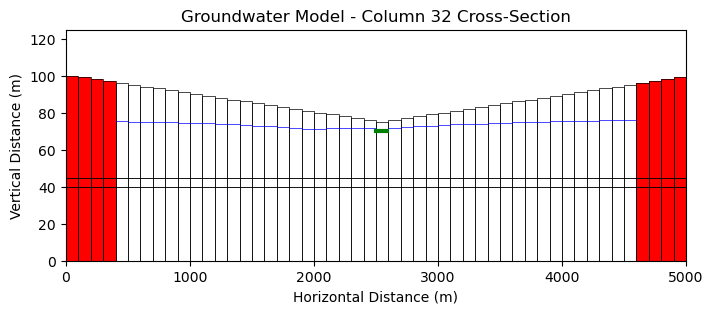

In [139]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=m, line={'column':32 }) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Vertical Distance (m)')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('Groundwater Model - Row 25 Cross-Section')
t = ax.set_title('Groundwater Model - Column 32 Cross-Section')

fname = modws+'/'+modelname+'.hds'
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
wtup = xsect.plot_surface(head[0], lw=0.5, alpha=1)
#wtlow = xsect.plot_surface(head[2], lw=0.5, alpha=0.5, color='purple')
#plt.plot(np.arange(0,5000,100),reach['strtop'][:],color='green',linestyle='dashed', lw=1.5)
#plt.plot(np.arange(0,5000,100),ztop[25][:],color='black',linestyle='solid', lw=1.5)
plt.plot(np.arange(2500,2600,10),np.repeat(reach['strtop'][32],10),color='green',linestyle='solid', lw=3)

#plt.legend()


## Read SFR outputs

In [140]:
#sfr_outfile = os.path.join(..', 'data', 'sfr_examples')
sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
df = sfrout.get_dataframe()
display(df)


,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,gradient,kstpkper,k,i,j
0,1,26,1,1,1,1.000,0.000,1.000,0.0,0.0,0.0,95.0003,0.000272,5.0,0.0,0.00000,"(0, 0)",0,25,0
1,1,26,2,1,2,1.000,1.000,0.000,0.0,0.0,0.0,94.0001,0.000061,5.0,300.0,1.00000,"(0, 0)",0,25,1
2,1,26,3,1,3,0.000,0.000,0.000,0.0,0.0,0.0,93.0000,0.000000,5.0,300.0,1.00000,"(0, 0)",0,25,2
3,1,26,4,1,4,0.000,0.000,0.000,0.0,0.0,0.0,92.0000,0.000000,5.0,300.0,1.00000,"(0, 0)",0,25,3
4,1,26,5,1,5,0.000,0.000,0.000,0.0,0.0,0.0,91.0000,0.000000,5.0,300.0,1.00000,"(0, 0)",0,25,4
5,1,26,6,1,6,0.000,0.000,0.000,0.0,0.0,0.0,90.0000,0.000000,5.0,300.0,1.00000,"(0, 0)",0,25,5
6,1,26,7,1,7,0.000,0.000,0.000,0.0,0.0,0.0,89.0000,0.000000,5.0,300.0,1.00000,"(0, 0)",0,25,6
7,1,26,8,1,8,0.000,0.000,0.000,0.0,0.0,0.0,88.0000,0.000000,5.0,300.0,1.00000,"(0, 0)",0,25,7
8,1,26,9,1,9,0.000,0.000,0.000,0.0,0.0,0.0,87.0000,0.000000,5.0,300.0,1.00000,"(0, 0)",0,25,8
9,1,26,10,1,10,0.000,0.000,0.000,0.0,0.0,0.0,86.0000,0.000000,5.0,300.0,1.00000,"(0, 0)",0,25,9


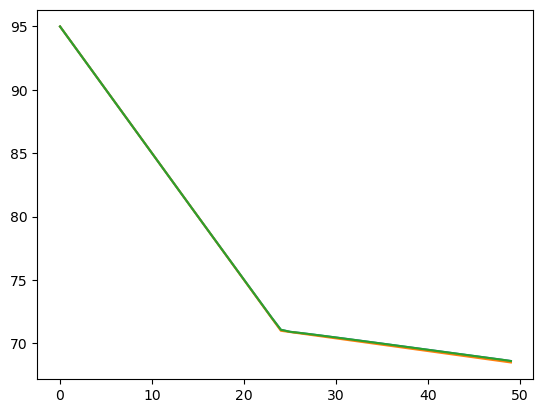

In [133]:
plt.plot(df.stage)
plt.plot(reach['strtop'])
plt.plot(df.depth +reach['strtop'])

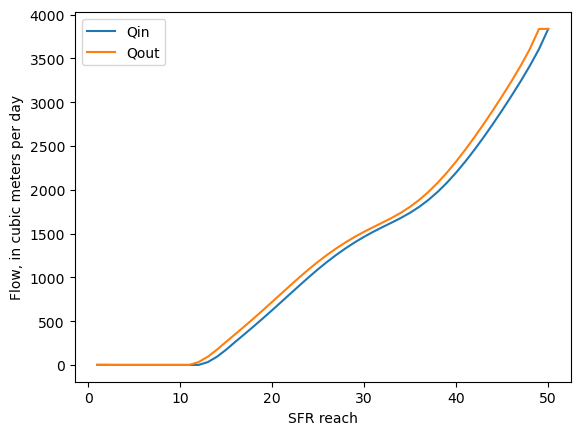

In [57]:
inds = df.segment == 1
#print(df.reach[inds].astype(str))
ax = df.loc[inds, ["reach", "Qin", "Qout"]].plot(x="reach")
ax.set_ylabel("Flow, in cubic meters per day")
ax.set_xlabel("SFR reach");